In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

#spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

#spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

3.8.10


In [2]:

import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 

import pandas as pd
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
pd.set_option('display.max_rows', None)


### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using emnist balanced data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [3]:
model_type = "powerlaw_all_epochs"

In [ ]:
#results_full_training = pd.read_csv("csv_files/Cifar10_acc_full_train_10_iterations_20230714.csv")
#results_full_training.head(20)
#mask = results_full_training.epoch == 195
#results_full_training[mask]

In [5]:
results = pd.read_csv("csv_files/emnist_train_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231103.csv")
results_val = pd.read_csv("csv_files/emnist_val_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231117.csv")
min_epoch = 30
min_sample_size = 50100



In [6]:
results.head(2)

,accs,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained
0,0.021277,4.356774,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,0
1,0.021277,5.514355,146.0,242.0,208.0,280.0,79.0,11.0,60.0,396.0,86.0,176.0,128.0,47.0,282.0,131.0,22.0,655.0,46.0,77.0,1935.0,157.0,118.0,1.0,182.0,33.0,27.0,213.0,15.0,122.0,76.0,45.0,178.0,217.0,179.0,34.0,73.0,1813.0,21.0,270.0,53.0,225.0,3.0,99.0,97.0,19.0,98.0,268.0,360.0,2


In [7]:
112800 / 47 # number of images per class in full dataset
100000/47

2127.659574468085

In [8]:
results.head(2)
results.epochs_trained.unique()

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90])

In [9]:
mask = results.epochs_trained >= min_epoch
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= min_epoch
results_val = results_val[mask].reset_index(drop=True)

classes = results.columns.tolist()[2:-1]
#classes
print(classes)
results["total_training_size"] = results[classes].sum(axis=1)
mask = results.total_training_size > min_sample_size
results = results[mask].reset_index(drop=True)
results_orig = results.copy()
results_val["total_training_size"] = results_val[classes].sum(axis=1)
mask = results_val.total_training_size > min_sample_size
results_val = results_val[mask].reset_index(drop=True)
results.head(4)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


,accs,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size
0,0.827394,34.350011,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,30,59998.0
1,0.829043,34.414285,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,32,59998.0
2,0.828830,34.369853,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,34,59998.0
3,0.821809,34.402688,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,36,59998.0


In [10]:
print(results.shape)
mask = (results.epochs_trained % 4 == 2)
results = results[mask].reset_index(drop=True)
print(results.shape)
 

(21700, 51)
(11200, 51)


In [11]:
results.total_training_size.unique()

array([ 59998.,  60005.,  59995.,  60001.,  59997.,  59991.,  60002.,
        60004.,  60000.,  60003.,  60008.,  60006.,  59999.,  59996.,
        59992.,  59994.,  60009.,  60007.,  59993.,  69994.,  70002.,
        70007.,  69998.,  69991.,  69997.,  69996.,  70005.,  69992.,
        70011.,  70006.,  69999.,  70003.,  69995.,  70000.,  70001.,
        70008.,  70004.,  69993.,  69990.,  70010.,  70009.,  80008.,
        79993.,  79999.,  80002.,  80006.,  80009.,  80005.,  79995.,
        79994.,  80004.,  79992.,  80003.,  80011.,  79996.,  80010.,
        79998.,  80013.,  80001.,  80000.,  79990.,  79997.,  80007.,
        79988.,  79989.,  79987.,  80012.,  79991.,  79986.,  80014.,
        89989.,  89996.,  90010.,  90008.,  89998.,  90002.,  89990.,
        90004.,  90001.,  90009.,  89992.,  90006.,  89988.,  89999.,
        89987.,  90012.,  89993.,  89994.,  89986.,  90014.,  90005.,
        90000.,  90007.,  90013.,  89995.,  89997.,  90011.,  89991.,
        90015.,  900

In [12]:
print(results[["accs"] + classes + ["epochs_trained", "total_training_size"]].iloc[:5, :].to_latex(float_format="{:.2f}".format))

### constructing a pred dataset: 
results_pred = results[["training_times"] + classes + ["epochs_trained", "total_training_size"]].copy()
row = {c: 2400 for c in classes}
row["epochs_trained"] = 90
row["total_training_size"] = 112800 
row["training_times"] = 100
results_pred = results_pred.append(row, ignore_index=True)
row = {c: 2400 for c in classes}
row["training_times"] = 45
row["epochs_trained"] = 70
row["total_training_size"] =  112800
results_pred = results_pred.append(row, ignore_index=True)
results_pred = results_pred.iloc[-2:,:].reset_index(drop=True)

for c_max in classes:
    row = {c: 2120 for c in classes}
    row[c_max] = 2400
    row["epochs_trained"] = 90
    row["training_times"] = 100
    row["total_training_size"] =  2120 * 47 + 2400
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 70
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 30
    results_pred = results_pred.append(row, ignore_index=True)
    
for c_max in classes:
    row = {c: 1800 for c in classes}
    row[c_max] = 2400
    row["epochs_trained"] = 90
    row["training_times"] = 100
    row["total_training_size"] =  1800*46 + 2400
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 70
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 30
    results_pred = results_pred.append(row, ignore_index=True)

results_pred_orig = results_pred.copy()

scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)


# using the same scaler for val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val_orig = results_val.copy()
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

# using the same scaler for pred tries:
results_scaled_pred = pd.DataFrame(scaler.transform(results_pred))
results_scaled_pred.columns = results_pred.columns
results_pred = results_scaled_pred
results_pred


xdata = np.transpose(results.to_numpy()[:, 2:])
y = results.to_numpy()[:, 0]
#xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
xdata_val = np.transpose(results_val.to_numpy()[:, 2:])
y_val = results_val.to_numpy()[:, 0]
xdata.shape
#xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:-1])
xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:])
xdata_pred.shape

mask = results.epochs_trained == 1
results_last_epoch = results[mask].reset_index(drop=True)
xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
y_last_epoch = results_last_epoch.to_numpy()[:, 0]

mask = results_val.epochs_trained == 1
results_val_last_epoch = results_val[mask].reset_index(drop=True)
xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]

# data for total_n and epoch only:
xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
xpred_total_n_epoch = np.transpose(results_pred.to_numpy()[:, -2:])
xpred_total_n_epoch.shape

# data for last epoch, total_n only:
xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])


results_dict = {"classes": classes, 
            "xdata": xdata, 
            "y": y, 
            "xdata_val": xdata_val, 
            "y_val": y_val, 
            "xdata_pred": xdata_pred, 
            #"xdata_4500": xdata_4500, 
            #"y_4500": y_4500, 
            "results": results, 
            "results_orig": results_orig,
            "results_val": results_val, 
            "results_val_orig": results_val_orig, 
            #"results_4500": results_4500, 
            "results_pred": results_pred, 
            #"results_4500_orig": results_4500_orig, 
            "results_pred_orig": results_pred_orig, 
            "xdata_last_epoch": xdata_last_epoch, 
            "y_last_epoch": y_last_epoch, 
            "xdata_val_last_epoch": xdata_val_last_epoch, 
            "y_val_last_epoch": y_val_last_epoch, 
            "xdata_total_n_epoch": xdata_total_n_epoch, 
            "xdata_val_total_n_epoch": xdata_val_total_n_epoch}


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  accs &       0 &      1 &      2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 &       A &       B &       C &      D &       E &      F &       G &       H &       I &       J &       K &      L &      M &      N &       O &      P &       Q &       R &       S &       T &      U &      V &       W &      X &       Y &      Z &       a &      b &      d &       e &      f &     g &       h &      n &      q &       r &       t &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.83 & 1160.00 & 741.00 & 552.00 & 1164.00 & 1486.00 & 1932.00 & 2354.00 & 2354.00 & 2354.00 & 1094.00 & 1194.00 & 1132.00 & 2354.00 & 629.00 & 1412.00 & 633.00 & 2354.00 & 2354.00 & 1890.00 & 1277.00 & 1140.00 & 779.00 & 500.00 & 200.00 & 2354.00 & 505.00 & 2354.00 & 1517.00 & 1291.00 & 2119.00 & 903.00 & 955.00 & 1130.00 & 350.00 & 1919.00 & 883.00 & 1116.00 & 292.00 & 933.00 & 1570.00 & 899.00

In [13]:
#results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jf_batch_size_512_reset_fc_output_size_mixture_design_maximin_20230927.csv")
#results_val_from_file = pd.read_csv("csv_files/Cifar10_val_acc_subsets_thomas_batch_size_512_reset_fc_output_size_mixture_design_maximin_20231103.csv")
# the following may need to be recalculated?
#results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#results_from_file = pd.read_csv("csv_files/emnist_train_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231103.csv")
#results_val_from_file = pd.read_csv("csv_files/emnist_val_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231117.csv")

#print(results_from_file.shape)
#display(results_from_file.head(-10))
#print(results_val_from_file.shape)
#display(results_from_file.head(-10))
#prep_data
#data_dict = prep_data.prep_data_all_epochs(results_from_file, results_val_from_file, results_4500_from_file, min_epoch = 20)

# the following unpacks all dict items into a corresponding variable:
#locals().update(data_dict)
locals().update(results_dict)


In [14]:
results_orig.epochs_trained.unique()
results_orig.head(20)

,accs,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size
0,0.827394,34.350011,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,30,59998.0
1,0.829043,34.414285,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,32,59998.0
2,0.828830,34.369853,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,34,59998.0
3,0.821809,34.402688,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,36,59998.0
4,0.824521,34.373259,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,38,59998.0
5,0.821755,34.385615,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,40,59998.0
6,0.828404,34.389398,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,42,59998.0
7,0.826436,34.362639,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,44,59998.0
8,0.834894,34.380512,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,46,59998.0
9,0.830798,34.346317,1160.0,741.0,552.0,1164.0,1486.0,1932.0,2354.0,2354.0,2354.0,1094.0,1194.0,1132.0,2354.0,629.0,1412.0,633.0,2354.0,2354.0,1890.0,1277.0,1140.0,779.0,500.0,200.0,2354.0,505.0,2354.0,1517.0,1291.0,2119.0,903.0,955.0,1130.0,350.0,1919.0,883.0,1116.0,292.0,933.0,1570.0,899.0,72.0,1815.0,152.0,936.0,1603.0,1291.0,48,59998.0


# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [15]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    running_sum = 0    
    for i in range(n_param):
        running_sum += args[i] * x[i]        
    return a + ((running_sum)**b) * c


In [16]:
np.random.seed(seed=4213523)
n_p = len(classes) + 3 + 1 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)

#params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))
params, params_cov = curve_fit(func, xdata, y, maxfev=50000, p0=p0)

print(params.shape, len(classes))
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]

/tmp/ipykernel_21841/1336897214.py:7: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c


(51,) 47


param_name,a,b,c,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epoch
param_value,0.141162,0.140433,0.413811,1.366972,1.565406,0.425277,-0.386424,0.582888,1.086084,1.789062,0.610194,1.226133,2.487841,1.762614,1.372404,0.019607,1.730165,0.530866,0.808268,2.177951,0.5434,1.821732,1.324978,1.255093,0.2475,1.485387,1.506962,1.030528,1.200643,2.166145,0.45492,2.145488,1.415323,0.558545,1.170061,0.638234,-0.000745,0.488722,0.729047,1.774019,0.478544,0.518596,0.606359,0.340274,1.048301,1.349093,0.358289,0.658222,0.761231,0.435659,-1.273065


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &    a &    b &    c &    0 &    1 &    2 &     3 &    4 &    5 &    6 &    7 &    8 &    9 &    A &    B &    C &    D &    E &    F &    G &    H &    I &    J &    K &    L &    M &    N &    O &    P &    Q &    R &    S &    T &    U &    V &    W &     X &    Y &    Z &    a &    b &    d &    e &    f &    g &    h &    n &    q &    r &    t &  epoch \\
\midrule
param\_value & 0.14 & 0.14 & 0.41 & 1.37 & 1.57 & 0.43 & -0.39 & 0.58 & 1.09 & 1.79 & 0.61 & 1.23 & 2.49 & 1.76 & 1.37 & 0.02 & 1.73 & 0.53 & 0.81 & 2.18 & 0.54 & 1.82 & 1.32 & 1.26 & 0.25 & 1.49 & 1.51 & 1.03 & 1.20 & 2.17 & 0.45 & 2.15 & 1.42 & 0.56 & 1.17 & 0.64 & -0.00 & 0.49 & 0.73 & 1.77 & 0.48 & 0.52 & 0.61 & 0.34 & 1.05 & 1.35 & 0.36 & 0.66 & 0.76 & 0.44 &  -1.27 \\
\bottomrule
\end{tabular}

0.00015814510977342174


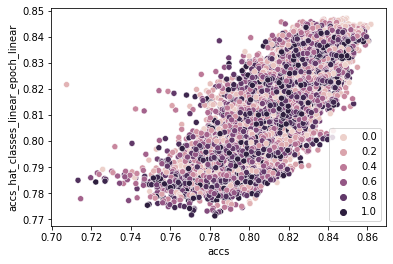

0.6818034643846427
mean val loss: 0.00019332205761748368


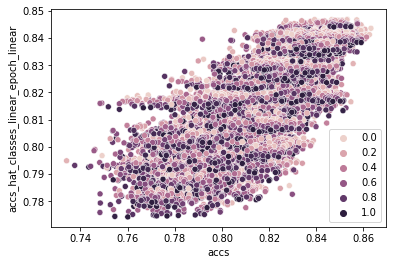

r_square val: 0.6298514191269546


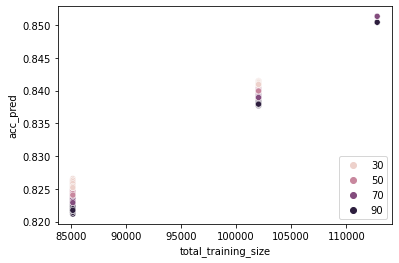

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.850457
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.851365


In [17]:
#def plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False):
# some plotting parameters
saving_plots = False
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
param_df = param_df.set_index("param_name").T
HTML(display(param_df))
print(param_df.to_latex(float_format="{:.2f}".format))
y_hat = func(xdata, *params)
print(((y_hat - y)**2).mean())
# dataframe for plotting:
results[y_hat_name] = y_hat


sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
plt.show()
print(metrics.r2_score(results.accs, results[y_hat_name]))
# val data:
y_val_hat = func(xdata_val, *params)
print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
# dataframe for plotting:
results_val[y_hat_name] = y_val_hat

sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
plt.show()

print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

acc_pred = func(xdata_pred, *params)
results_pred_orig["acc_pred"] = acc_pred
sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
plt.legend(loc = 'lower right')
plt.show()
display(results_pred_orig.head(2))


is_2param = False
if is_2param:
    param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
    param_unstacked.columns = ["feature", "param_no"]
    param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
    param_unstacked = param_unstacked.set_index(["feature", "param_no"])
    param_unstacked = param_unstacked.unstack()
    display(param_unstacked)

    param_unstacked.iloc[:,1]
    plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
    plt.xlabel("parameter height")
    plt.ylabel("parameter width")
    for i in range(param_unstacked.shape[0]):
        plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
    if saving_plots:
        plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_param1_vs_param2.jpg")
    plt.show()



### using an arctan effect for every class:

In [18]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a, b, c, *args) -> float:
    running_sum = 0
    # n_param is implicitely handed over, in order to not introduce a further parameter into curve_fit    
    for i in range(n_param):
        running_sum += args[2*i]* np.arctan(args[2*i + 1] * x[i])         
    return a + ((running_sum)**b) * c


In [19]:
xdata.shape
n_param

48

In [20]:
# this cell runs approx. 7 minutes
np.random.seed(seed=4213523)
n_p = 2 * len(classes) + 3 + 2 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)
params, params_cov = curve_fit(func, xdata, y, maxfev=500000, p0=p0)
# strange enough, with bounds the optimzation takes way longer
# params, params_cov = curve_fit(func, xdata, y, maxfev=20000, p0=p0, bounds=(-10, 30)) 


/tmp/ipykernel_21841/1048484364.py:8: RuntimeWarning: invalid value encountered in power
  return a + ((running_sum)**b) * c


In [21]:
param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]

In [22]:
params

array([-1.03868172e+00,  3.30518652e-01,  5.00842735e-01,  4.98120264e-01,
        8.57981945e+00,  4.49527062e-01,  3.58339833e+00,  6.69747993e-01,
        2.63569711e+01,  8.61150855e-01,  1.15509592e+02,  7.43858414e-01,
        3.04575159e+01,  8.62610328e-01,  4.00788730e+01,  6.44566706e-01,
        1.55308319e+01,  7.59246756e-01,  4.42728167e+01,  8.75768655e-01,
        2.89447811e+01,  7.86421116e-01,  4.06089803e+00,  1.00524083e+00,
        5.64436176e+01,  1.01760330e+00,  3.31966160e+01,  2.73198379e-01,
        3.09129583e+01,  6.78518220e-01,  1.95918044e+01,  9.19696001e-01,
        6.31980355e+01,  3.19563087e-01,  1.13818543e+01,  9.00862848e-01,
        2.32135574e+01,  9.03782368e-01,  7.45211456e+01,  5.86732681e-01,
        1.29664666e+01,  8.71941773e-01,  4.67588983e+01,  9.89007755e-01,
        4.14087574e+01,  1.77236241e-01,  6.46915878e+00,  9.50758358e-01,
        2.86857482e+01,  9.93354750e-01,  1.84977629e+01,  3.62125202e-01,
        6.25986892e+00,  

param_name,a,b,c,0_1,0_2,1_1,1_2,2_1,2_2,3_1,3_2,4_1,4_2,5_1,5_2,6_1,6_2,7_1,7_2,8_1,8_2,9_1,9_2,A_1,A_2,B_1,B_2,C_1,C_2,D_1,D_2,E_1,E_2,F_1,F_2,G_1,G_2,H_1,H_2,I_1,I_2,J_1,J_2,K_1,K_2,L_1,L_2,M_1,M_2,N_1,N_2,O_1,O_2,P_1,P_2,Q_1,Q_2,R_1,R_2,S_1,S_2,T_1,T_2,U_1,U_2,V_1,V_2,W_1,W_2,X_1,X_2,Y_1,Y_2,Z_1,Z_2,a_1,a_2,b_1,b_2,d_1,d_2,e_1,e_2,f_1,f_2,g_1,g_2,h_1,h_2,n_1,n_2,q_1,q_2,r_1,r_2,t_1,t_2,epoch_1,epoch_2
param_value,-1.038682,0.330519,0.500843,0.49812,8.579819,0.449527,3.583398,0.669748,26.356971,0.861151,115.509592,0.743858,30.457516,0.86261,40.078873,0.644567,15.530832,0.759247,44.272817,0.875769,28.944781,0.786421,4.060898,1.005241,56.443618,1.017603,33.196616,0.273198,30.912958,0.678518,19.591804,0.919696,63.198036,0.319563,11.381854,0.900863,23.213557,0.903782,74.521146,0.586733,12.966467,0.871942,46.758898,0.989008,41.408757,0.177236,6.469159,0.950758,28.685748,0.993355,18.497763,0.362125,6.259869,1.07126,57.915401,0.909092,13.804575,1.069923,52.298864,0.75826,11.329895,0.76389,30.161097,0.878039,71.728327,0.861691,46.041392,1.096684,77.279313,1.170112,107.750261,0.838659,44.412263,0.64821,20.586449,0.885991,26.548584,0.819234,51.593309,1.229544,218.394066,0.834844,31.489137,0.275662,10.04492,0.458005,14.250765,0.584521,32.11226,0.870133,75.488399,0.361732,4.996484,1.237035,112.253223,0.836978,50.118602,-0.319808,1.378833


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
param\_name &     a &    b &    c &  0\_1 &  0\_2 &  1\_1 &  1\_2 &  2\_1 &   2\_2 &  3\_1 &    3\_2 &  4\_1 &   4\_2 &  5\_1 &   5\_2 &  6\_1 &   6\_2 &  7\_1 &   7\_2 &  8\_1 &   8\_2 &  9\_1 &  9\_2 &  A\_1 &   A\_2 &  B\_1 &   B\_2 &  C\_1 &   C\_2 &  D\_1 &   D\_2 &  E\_1 &   E\_2 &  F\_1 &   F\_2 &  G\_1 &   G\_2 &  H\_1 &   H\_2 &  I\_1 &   I\_2 &  J\_1 &   J\_2 &  K\_1 &   K\_2 &  L\_1 &  L\_2 &  M\_1 &   M\_2 &  N\_1 &   N\_2 &  O\_1 &  O\_2 &  P\_1 &   P\_2 &  Q\_1 &   Q\_2 &  R\_1 &   R\_2 &  S\_1 &   S\_2 &  T\_1 &   T\_2 &  U\_1 &   U\_2 &  V\_1 &   V\_2 &  W\_1 &   W\_2 &  X\_1 &    X\_2 &  Y\_1 &   Y\_2 &  Z\_1 &   Z\_2 &  a\_1 &   a\_2 &  b\_1 &   b\_2 &  d\_1 &    d\_2 &  e\_1 &   e\_2 &  f\_1 &   f\_2 &  g\_1 &   g\_2 &  h\_1 &   h\_2 &  n\_1 &   n\_2 &  q\_1 &  q\_2 &  r\_1 &    r\_2 &  t\_1 &   t\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\

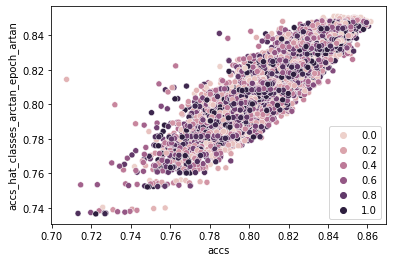

0.8442473723090705
mean val loss: 8.519762286871009e-05


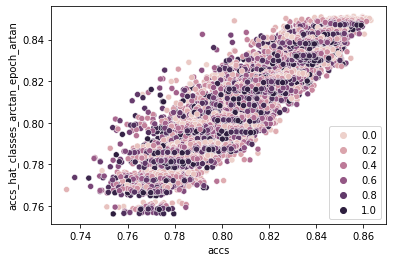

r_square val: 0.836874386775832


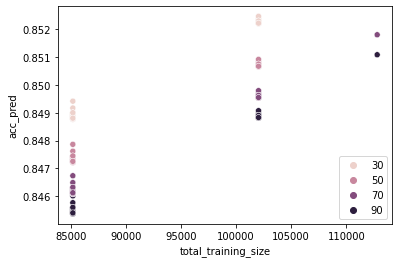

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.851088
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.851807


param_value            
param_no           1           2
feature                         
0           0.498120    8.579819
1           0.449527    3.583398
2           0.669748   26.356971
3           0.861151  115.509592
4           0.743858   30.457516
5           0.862610   40.078873
6           0.644567   15.530832
7           0.759247   44.272817
8           0.875769   28.944781
9           0.786421    4.060898
A           1.005241   56.443618
B           1.017603   33.196616
C           0.273198   30.912958
D           0.678518   19.591804
E           0.919696   63.198036
F           0.319563   11.381854
G           0.900863   23.213557
H           0.903782   74.521146
I           0.586733   12.966467
J           0.871942   46.758898
K           0.989008   41.408757
L           0.177236    6.469159
M           0.950758   28.685748
N           0.993355   18.497763
O           0.362125    6.259869
P           1.071260   57.915401
Q           0.909092   13.804575
R           1.069923   52.298864
S           0.758260   11.329895
T           0.763890   30.161097
U           0.878039   71.728327
V           0.861691   46.041392
W           1.096684   77.279313
X           1.170112  107.750261
Y           0.838659   44.412263
Z           0.648210   20.586449
a           0.885991   26.548584
b           0.819234   51.593309
d           1.229544  218.394066
e           0.834844   31.489137
epoch      -0.319808    1.378833
f           0.275662   10.044920
g           0.458005   14.250765
h           0.584521   32.112260
n           0.870133   75.488399
q           0.361732    4.996484
r           1.237035  112.253223
t           0.836978   50.118602

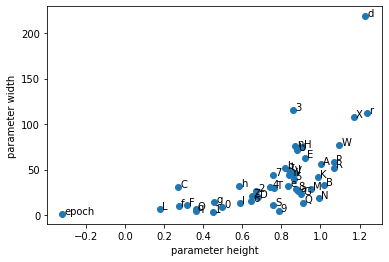

In [23]:
#def plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False):
# some plotting parameters
saving_plots = False
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
param_df = param_df.set_index("param_name").T
HTML(display(param_df))
print(param_df.to_latex(float_format="{:.2f}".format))
y_hat = func(xdata, *params)
print(((y_hat - y)**2).mean())
# dataframe for plotting:
results[y_hat_name] = y_hat


sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
plt.show()
print(metrics.r2_score(results.accs, results[y_hat_name]))
# val data:
y_val_hat = func(xdata_val, *params)
print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
# dataframe for plotting:
results_val[y_hat_name] = y_val_hat

sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
plt.show()

print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

acc_pred = func(xdata_pred, *params)
results_pred_orig["acc_pred"] = acc_pred
sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
plt.legend(loc = 'lower right')
plt.show()
display(results_pred_orig.head(2))


is_2param = True
if is_2param:
    param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
    param_unstacked.columns = ["feature", "param_no"]
    param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
    param_unstacked = param_unstacked.set_index(["feature", "param_no"])
    param_unstacked = param_unstacked.unstack()
    display(param_unstacked)

    param_unstacked.iloc[:,1]
    plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
    plt.xlabel("parameter height")
    plt.ylabel("parameter width")
    for i in range(param_unstacked.shape[0]):
        plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
    if saving_plots:
        plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_param1_vs_param2.jpg")
    plt.show()



# using all epochs, but just overall training dataset size:

In [24]:
xdata.shape

(49, 11200)

In [27]:
#xdata[48,0]


0.00017487758569001421

In [28]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_epoch = x[47]
    x_total_n = x[48]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)
n_p = 5
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

/tmp/ipykernel_21841/3805553269.py:7: RuntimeWarning: invalid value encountered in power
  return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c


In [30]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n", "epoch"]


    


param_name,a,b,c,total_n,epoch
param_value,0.789996,0.917338,0.060714,0.823886,1.529255e-08


\begin{tabular}{lrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n &  epoch \\
\midrule
param\_value & 0.79 & 0.92 & 0.06 &     0.82 &   0.00 \\
\bottomrule
\end{tabular}

0.0001773949487022761


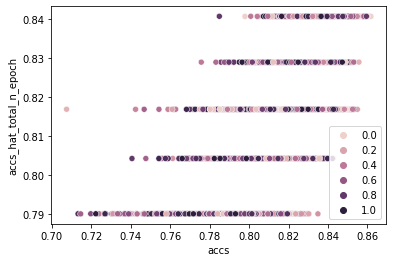

0.6430717447185028
mean val loss: 0.00019194201285901725


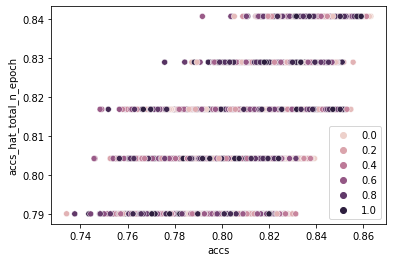

r_square val: 0.6324937539705986


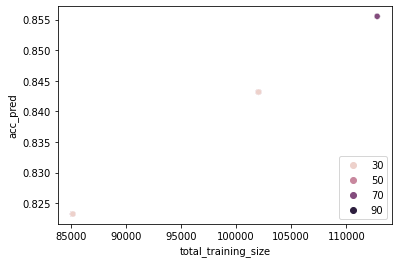

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.855535
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.855535


In [31]:
#def plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False):
# some plotting parameters
saving_plots = False
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
param_df = param_df.set_index("param_name").T
HTML(display(param_df))
print(param_df.to_latex(float_format="{:.2f}".format))
y_hat = func(xdata, *params)
print(((y_hat - y)**2).mean())
# dataframe for plotting:
results[y_hat_name] = y_hat


sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
plt.show()
print(metrics.r2_score(results.accs, results[y_hat_name]))
# val data:
y_val_hat = func(xdata_val, *params)
print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
# dataframe for plotting:
results_val[y_hat_name] = y_val_hat

sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
plt.show()

print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

acc_pred = func(xdata_pred, *params)
results_pred_orig["acc_pred"] = acc_pred
sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
plt.legend(loc = 'lower right')
plt.show()
display(results_pred_orig.head(2))






### Using the arctan trick also for the total_n model:

In [34]:
n_param

48

In [32]:
y_hat_name = "accs_hat_total_n_arctan_epoch_arctan"

def func(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_epoch = x[47]
    x_total_n = x[48]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

/tmp/ipykernel_21841/2644367418.py:6: RuntimeWarning: invalid value encountered in power
  return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c


param_name,a,b,c,total_n_1,total_n_2,epoch_1,epoch_2
param_value,0.787896,0.761677,0.234187,0.41734,0.336044,6.247463e-09,0.159509


\begin{tabular}{lrrrrrrr}
\toprule
param\_name &    a &    b &    c &  total\_n\_1 &  total\_n\_2 &  epoch\_1 &  epoch\_2 \\
\midrule
param\_value & 0.79 & 0.76 & 0.23 &       0.42 &       0.34 &     0.00 &     0.16 \\
\bottomrule
\end{tabular}

0.0001788483773714751


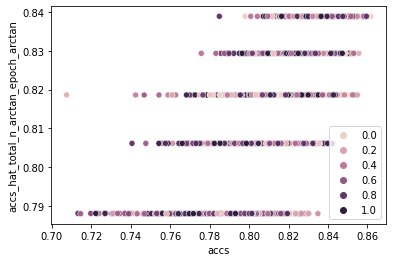

0.640147367430038
mean val loss: 0.0001939919942766549


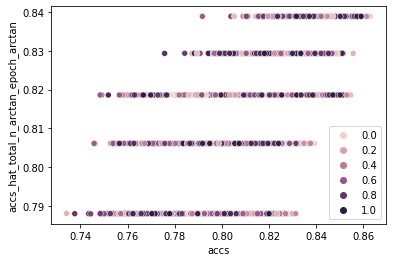

r_square val: 0.6285687092969273


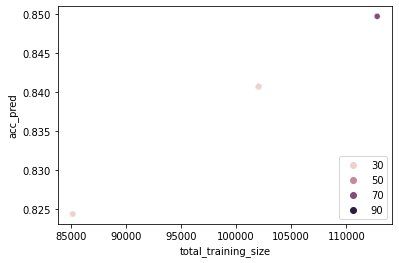

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,0.849756
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,0.849756


In [33]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n_1", "total_n_2", "epoch_1", "epoch_2"]

#def plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False):
# some plotting parameters
saving_plots = False
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
param_df = param_df.set_index("param_name").T
HTML(display(param_df))
print(param_df.to_latex(float_format="{:.2f}".format))
y_hat = func(xdata, *params)
print(((y_hat - y)**2).mean())
# dataframe for plotting:
results[y_hat_name] = y_hat


sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
plt.show()
print(metrics.r2_score(results.accs, results[y_hat_name]))
# val data:
y_val_hat = func(xdata_val, *params)
print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
# dataframe for plotting:
results_val[y_hat_name] = y_val_hat

sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
#plt.xlim((0.05, 0.9))
#plt.ylim((0.05, 0.9))
#plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
plt.show()

print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

acc_pred = func(xdata_pred, *params)
results_pred_orig["acc_pred"] = acc_pred
sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
plt.legend(loc = 'lower right')
plt.show()
display(results_pred_orig.head(2))


